# A/B tests с Python



# Урок 9. Python применение продвинутых методов
# Задание 1 (с семинара)
Оцените результаты эксперимента:<br>
Стат значимо ли отличается метрика конверсии в двух группах ?<br>
Какие рекомендации дадите менеджеру?


a_b test ecom.xlsx<br>
Для этого проекта вы будете работать над тем, чтобы понять результаты A/B тестирования, выполняемого на веб-сайте электронной коммерции. Компания разработала новую веб-страницу, чтобы попытаться увеличить число пользователей, которые «конвертируют», то есть количество пользователей, которые решат заплатить за продукт компании. Ваша цель - работать с этой записной книжкой, чтобы помочь компании понять, должны ли они внедрить эту новую страницу, сохранить старую страницу или, возможно, запустить эксперимент дольше, чтобы принять решение.


<a id="Libraries"></a>
##  Загрузка библиотек

In [1]:
from scipy.stats import ttest_1samp
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')



In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


#Поработаем с датасетом

##Подготовка данных

In [3]:
#Подгружаем данные
data = pd.read_excel('a_b test ecom.xlsx')

In [4]:
data.head(10)

,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1
5,936923,20:49.1,control,old_page,0
6,679687,26:46.9,treatment,new_page,1
7,719014,48:29.5,control,old_page,0
8,817355,58:09.0,treatment,new_page,1
9,839785,11:06.6,treatment,new_page,1


In [5]:
# Информация по датасету
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         294478 non-null  int64 
 1   time       294478 non-null  object
 2   con_treat  294478 non-null  object
 3   page       294478 non-null  object
 4   converted  294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [6]:
# Размерность датасета
data.shape

(294478, 5)

In [7]:
# Посмотрим основные статистики
data.describe()

,id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In [8]:
data.isna().sum()

id           0
time         0
con_treat    0
page         0
converted    0
dtype: int64

Пропущенных данных нет.

### Тестирование гипотез.

***Гипотеза для коэффициента корелляции.*** Как видно из данных, пользователи контрольной группы (50%) должны были остваться на старой странице, а пользователи тестовой группы (50%) должны были переходить на новую страницу.<br>
Таким образом, данные колонки "con_treat"	должны идеально коррелироваться с данными колонки "page".<br>
Проверим это.

In [9]:
from scipy.stats import pearsonr

In [10]:
data.con_treat_bool = data.apply(lambda x: 0 if x.con_treat=='control' else 1, axis=1)
data.page_bool = data.apply(lambda x: 0 if x.page=='old_page' else 1, axis=1)

stat, p = pearsonr(data.con_treat_bool, data.page_bool)

print('stat=%.3f, p=%.3f' % (stat, p))
if stat == 1:
    print('Группы идеально коррелируют')
else:
    print('Группы не идеально коррелируют')

stat=0.974, p=0.000
Группы не идеально коррелируют


Получили странный результат: группы немного различаются.<br>
Рассмотрим эти группы подробней.

In [11]:
data.new = data.apply(lambda x: 1 if (x.con_treat=='control' and x.page=='old_page') or
                                     (x.con_treat=='treatment' and x.page=='new_page') else 0, axis=1)
data.new.value_counts()

1    290585
0      3893
dtype: int64

3 893 пользователя посещяла "не свою" страницу!<br>

In [12]:
data.con_treat.value_counts()

treatment    147276
control      147202
Name: con_treat, dtype: int64

Объём выборок в каждой группе примерно одинаковый.

In [13]:
data.page.value_counts()

old_page    147239
new_page    147239
Name: page, dtype: int64

Число посетителей старой и новой страницы одинаково.

In [14]:
data[data['con_treat']=='control'].page.value_counts()

old_page    145274
new_page      1928
Name: page, dtype: int64

In [15]:
data[data['con_treat']=='treatment'].page.value_counts()

new_page    145311
old_page      1965
Name: page, dtype: int64

1 928 пользователей контрольной группы посетили новую страницу.<br>
1 965 пользователей тестовой группы посетили старую страницу.

Визуализируем зависимость между группой и видом страницы:

page       new_page  old_page
con_treat                    
control        1928    145274
treatment    145311      1965


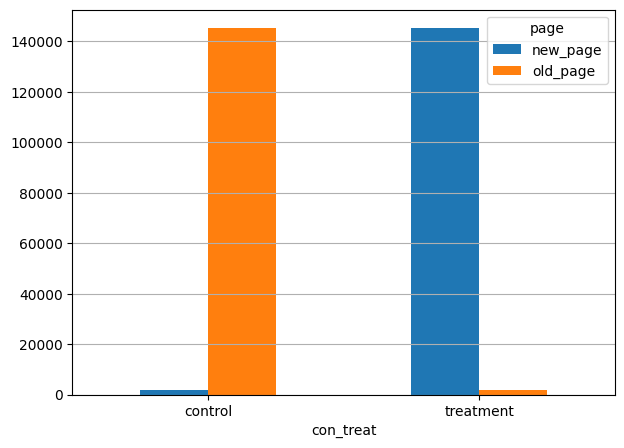

In [43]:
plt.style.use('default')

CrosstabResult=pd.crosstab(index=data['con_treat'],columns=data['page'])
print(CrosstabResult)

CrosstabResult.plot.bar(figsize=(7,5), rot = 0 )
plt.grid(axis = 'y')

## Поработаем с данными кейса. Почистим данные.
***Избавимся от некорретных строк.*** Уберём пользователей, которые попали не на "свою" страницу.

In [17]:
data_new = data[(data.con_treat=='control') & (data.page=='old_page') |
                  (data.con_treat=='treatment') & (data.page=='new_page')]

In [18]:
data_new.shape

(290585, 5)

Объём выборки уменьшился на 3 893 пользователей.

Визуализируем зависимость между группой и видом страницы:

page       new_page  old_page
con_treat                    
control           0    145274
treatment    145310         0


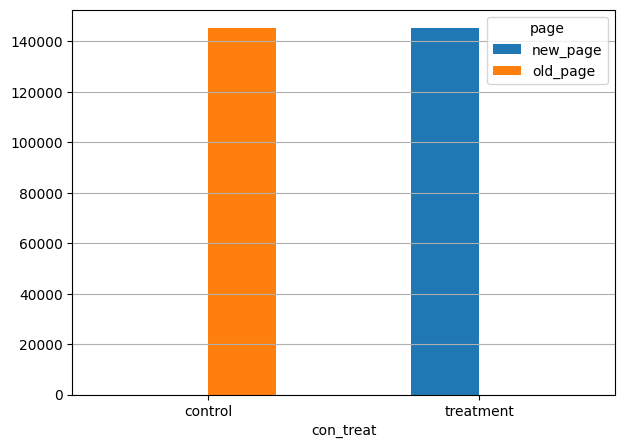

In [44]:
plt.style.use('default')

CrosstabResult=pd.crosstab(index=data_new['con_treat'],columns=data_new['page'])
print(CrosstabResult)

CrosstabResult.plot.bar(figsize=(7,5), rot = 0 )
plt.grid(axis = 'y')

Теперь у нас правильное распделение пользователей групп по "своим" страницам.

In [20]:
con_treat_bool = data_new.apply(lambda x: 0 if x.con_treat=='control' else 1, axis=1)
page_bool = data_new.apply(lambda x: 0 if x.page=='old_page' else 1, axis=1)

stat, p = pearsonr(con_treat_bool, page_bool)

print('stat=%.3f, p=%.3f' % (stat, p))
if round(stat, 3) == 1.0:
    print('Группы идеально коррелируют')
else:
    print('Группы не идеально коррелируют')

stat=1.000, p=0.000
Группы идеально коррелируют


Посчитаем, сколько типов групп встречается у каждого пользователя.<br>
И есть ли такие, которые попали и в контрольную, и в тестовую группу.

In [21]:
data_new.groupby('id', as_index=False).agg({'con_treat': pd.Series.nunique}).query('con_treat > 1')

,id,con_treat


Пользователи, которые попали в обе группы одновременно не вcтретились.<br>
Посчитаем, есть ли такие пользователи, которые попали больше одного раза.

In [22]:
data_new.shape[0] - data_new.id.nunique()

1

Один пользователь встречается несколько раз. Посмотрим на него.

In [23]:
data_new[data_new.duplicated("id") == True]

,id,time,con_treat,page,converted
2893,773192,55:59.6,treatment,new_page,0


In [24]:
data_new[data_new.id == 773192]

,id,time,con_treat,page,converted
1899,773192,37:58.8,treatment,new_page,0
2893,773192,55:59.6,treatment,new_page,0


***Избавимся от некорретной строки.*** Уберём одну строку, где пользователь попал второй раз в выборку.

In [25]:
data_new = data_new.drop_duplicates("id")

In [26]:
data_new.shape[0] - data_new.id.nunique()

0

In [27]:
data_new.shape

(290584, 5)

#Применение статистических критериев

##Метрика конверсия на юзера

Чтобы решить, является ли новая страница более успешной, рассмотрим метрику конверсия на пользователя. Рассчитаем коээффициент упешности конверсии.

Для измерения этого коэффициента успешности можно использовать коэффициент конверсии. Используем двоичную переменную:
* 0: Пользователь не оплатил продукт
* 1: Пользователь платит за продукт<br>

Далее вычислим среднее значение каждой группы (контроль и тест), чтобы получить скорость преобразования каждой страницы.

Посмотрим на группы по-отдельности:

In [28]:
data_new[data_new['con_treat']=='control'].describe()

,id,converted
count,145274.000000,145274.000000
mean,788164.072594,0.120386
std,91287.914601,0.325414
min,630002.000000,0.000000
25%,709279.500000,0.000000
50%,788128.500000,0.000000
75%,867208.250000,0.000000
max,945998.000000,1.000000


In [29]:
data_new[data_new['con_treat']=='treatment'].describe()

,id,converted
count,145310.000000,145310.000000
mean,787845.719290,0.118808
std,91161.564429,0.323564
min,630000.000000,0.000000
25%,708745.750000,0.000000
50%,787876.000000,0.000000
75%,866718.750000,0.000000
max,945999.000000,1.000000


Пока мы еще ничего не посчитали, но уже можно заметить, что наши выборки очень похожи.<br>
Среднее и среднеквадратичное отклонения в группах схожи между собой.

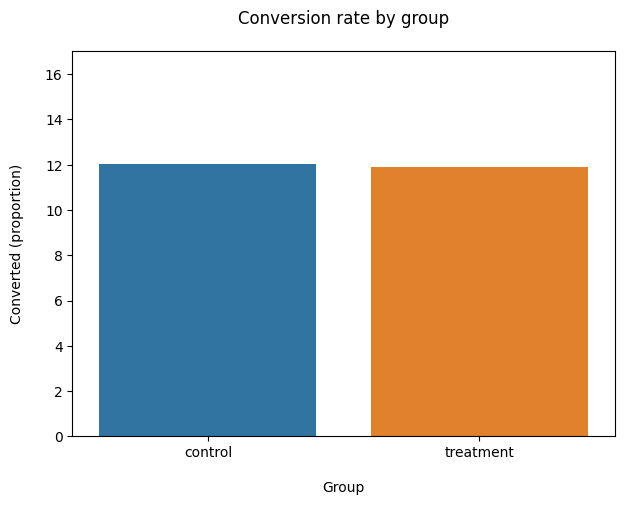

In [45]:
plt.figure(figsize=(7,5))

sns.barplot(x=data_new['con_treat'], y=data_new['converted']*100, ci=False)

plt.ylim(0, 17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

Первоначальные данные свидетельствуют об отсутствии существенной разницы в сходимости между тестовой группой и контрольной группой. Поэтому мы можем сделать вывод, что новая страница не оказывает никакого влияния и не приводит к большему количеству конверсий.

Тем не менее, для сравнения, мы проведём проверку гипотез, чтобы увидеть, подтверждение графической проверке.

##Проверка гипотез (A/B-тест)
Выполним статистический тест для сравнения этих двух групп.<br>
Учитывая наш большой размер выборки, мы можем использовать ***z-тест*** для расчета нашего p-значения.<br> В противном случае вместо этого может быть выполнен тест t-student.

Давайте рассчитаем p-значение и доверительный интервал для каждой группы

In [31]:
data_new['converted'].value_counts()

0    255831
1     34753
Name: converted, dtype: int64

In [32]:
k1 = data_new[data_new['con_treat']=='control']['converted'].sum()
k2 = data_new[data_new['con_treat']=='treatment']['converted'].sum()
k1, k2

(17489, 17264)

In [33]:
n1 = data_new[data_new['con_treat']=='control'].shape[0]
n2 = data_new[data_new['con_treat']=='treatment'].shape[0]
n1, n2

(145274, 145310)

In [34]:
from statsmodels.stats import proportion

In [35]:
z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]),
                                                 np.array([n1, n2]))
print('Результаты z_score = %.3f, p-value = %.3f'%(z_score, z_pvalue))

Результаты z_score = 1.311, p-value = 0.190


In [36]:
if abs(z_pvalue) < 0.05:
    print("Мы можем отвергнуть нулевую гипотезу! Стат. значимость существует.")
else:
    print("Мы не можем отвергнуть нулевую гипотезу. Стат. значимость не обнаружена.")

Мы не можем отвергнуть нулевую гипотезу. Стат. значимость не обнаружена.


In [37]:
(lower_con, lower_treat), (upper_con, upper_treat) = proportion.proportion_confint(np.array([k1, k2]),
                                                                                   np.array([n1, n2]), alpha=0.05)
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

ci 95% for control group: [0.119, 0.122]
ci 95% for treatment group: [0.117, 0.120]


Наилучший метод чтобы проверить статистическую значимость изменения для пропорций это метод Хи‑Квадрат.<br>
***Непараметрический Хи-квадрат:***

In [38]:
from scipy.stats import norm

In [39]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([k1, k2]),
                                                        np.array([n1, n2]))

# Рассчитаем доверительный интервал для изменения
lift = (n1/n2)/(k1/k2)
std_error = np.sqrt(1/n1 + 1/n2 + 1/k1 + 1/k2)
ci = norm.interval(0.95, loc=lift, scale=std_error)

# Выводим результаты
print(f"Хи-квадрат = {chisq} p-value = {pvalue}")
print("Доверительный интервал изменения: ", ci)

# Проверяем есть ли изменение
if pvalue < 0.05 and ci[0] > 1:
    print("Вариант лучше.")
else:
    print("Стат.разницы нет.")

Хи-квадрат = 1.7185222540121272 p-value = 0.18988337448194853
Доверительный интервал изменения:  (0.9646406761449434, 1.0091397469371604)
Стат.разницы нет.


In [46]:
if abs(pvalue) < 0.05:
    print("Мы можем отвергнуть нулевую гипотезу! Стат. значимость существует.")
else:
    print("Мы не можем отвергнуть нулевую гипотезу. Стат. значимость не обнаружена.")

Мы не можем отвергнуть нулевую гипотезу. Стат. значимость не обнаружена.



***Непараметрический критерий Манна-Уитни:***

In [47]:
data.groupby('con_treat')['converted'].describe()

,count,mean,std,min,25%,50%,75%,max
con_treat,,,,,,,,
control,147202.0,0.120399,0.325429,0.0,0.0,0.0,0.0,1.0
treatment,147276.0,0.118920,0.323695,0.0,0.0,0.0,0.0,1.0


In [48]:
from scipy.stats import mannwhitneyu

In [50]:
mw_stats = mannwhitneyu(x=data_new[data_new['con_treat'] == 'control']['converted'].values,
                        y=data_new[data_new['con_treat'] == 'treatment']['converted'].values,
                        alternative='two-sided')
mw_stats

MannwhitneyuResult(statistic=10571540597.0, pvalue=0.1898841499342626)

In [51]:
print("Mann-Whitney U-test:")
print("U-statistic: ", mw_stats[0])
print("p-value:     ", mw_stats[1])

Mann-Whitney U-test:
U-statistic:  10571540597.0
p-value:      0.1898841499342626


In [52]:
if abs(mw_stats[1]) < 0.05:
    print("Мы можем отвергнуть нулевую гипотезу! Стат. значимость существует.")
else:
    print("Мы не можем отвергнуть нулевую гипотезу. Стат. значимость не обнаружена.")

Мы не можем отвергнуть нулевую гипотезу. Стат. значимость не обнаружена.


Мы проверили 3 критериями: z-тест, Хи-квадрат и Манна-Уитни.<br>
***Стат. значимость не обнаружена!***

##Расчет мощности


***Статистическая мощность проверки гипотезы*** - это вероятность обнаружения эффекта, если существует истинный эффект, который необходимо обнаружить.
Мощность может быть рассчитана и зарегистрирована для завершенного эксперимента, чтобы прокомментировать уверенность, которую можно иметь в выводах, сделанных на основе результатов исследования.

d = (M1 – M2) / S_pooled






## S_pooled =

  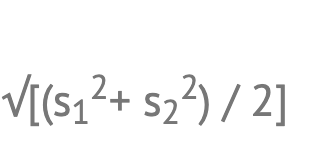

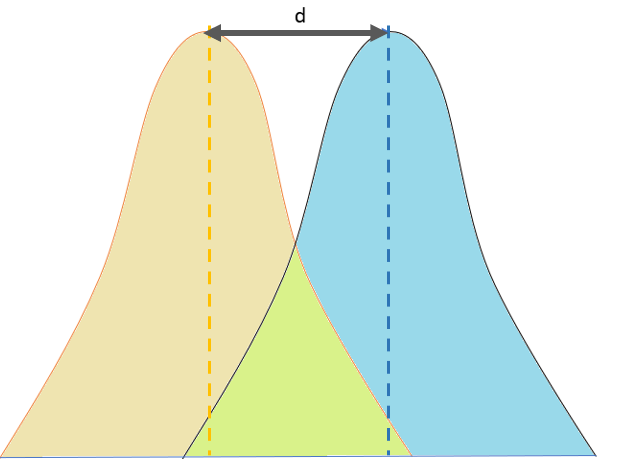

In [55]:
control = data_new.query('con_treat == "control"')
test = data_new.query('con_treat == "treatment"')

In [56]:
C_mean = control.converted.values.mean()
T_mean = test.converted.values.mean()

C_std = control.converted.values.std()
T_std = test.converted.values.std()

In [57]:
print(len(control.converted.values), len(test.converted.values))

145274 145310


In [58]:
n =  len(control.converted.values)

In [59]:
##S = np.sqrt((sd_t**2 / n_t) + (sd_c**2 / n_c))

S = np.sqrt((T_std**2 + C_std **2)/ 2)

In [60]:
effect =float((T_mean-C_mean)/ S)

In [61]:
from statsmodels.stats.power import TTestIndPower

In [62]:
# parameters for power analysis

alpha = 0.05

# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=None, nobs1=n, ratio=1.0, alpha=alpha)

result

0.258666000105756

***Статистическая мощность*** — это вероятность того, что тест правильно отклонит ложную нулевую гипотезу.<br>
Получили очень маленькую мощность теста, всего примерно 26%<br>
Между выборками нет различий с вероятностью 26%

Что делать, чтобы повысить мощность теста?<br>
Возможно нам не хватает объёма выборки?

In [63]:
# вычисление размера выборок на основе количества уникальных значений id
n1 = len(data[data['con_treat'] == 'control']['id'].unique())
n2 = len(data[data['con_treat'] == 'treatment']['id'].unique())

# вычисление ожидаемого эффекта на основе наблюдаемого эффекта
observed_effect = data[data['con_treat'] == 'treatment']['converted'].mean() - data[data['con_treat'] == 'control']['converted'].mean()
effect_size = observed_effect / data['converted'].std()

# задание параметров теста
alpha = 0.05  # уровень значимости
power = 0.8  # мощность теста

# вычисление мощности теста
power_analysis = TTestIndPower()
sample_size = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=n2/n1)
power = power_analysis.power(effect_size=effect_size, nobs1=sample_size, alpha=alpha, ratio=n2/n1)

# вывод результатов
print("Требуемый размер выборки: ", sample_size)
print("Мощность теста:           ", power)

Требуемый размер выборки:  755118.0996670319
Мощность теста:            0.8


Чтобы повысить статистическую мощность теста до 80%, нам необходимо повысить объём выборки до примерно 755 200 человек.

## Выводы:

1. У нас нет статистически значимой разницы по метрике конверсии между контрольной  и тестовой группами.
2. Тест изначательно был поставлен не корректно, 3 893 пользователя посещали "не свою" страницу, а один пользователь попал в тест 2 раза.
3. Мощность теста очень маленькая, чтобы с уверенностью сказать, что у нас действительно нет статистической значимости между группами.
4. У нас недостаточный объём выборки.

##Рекомендации менеджеру:

1. **Не рекомендую выкатывать изменения в продакшен.** Новая страница не увеличивает конверсию.
2. Перезапустить тест. Поставить тест корректно, проверить сплитование.
3. Увеличить объём выборки до 760 000 и время проведения эксперимента.

# Задание 2
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.<br>
Mobile Games AB Testing with Cookie Cats

результаты А_B.xlsx<br>
Данные у нас есть от 90 189 игроков, которые установили игру, пока работал AB-тест.<br>
Когда игрок устанавливал игру, он или она были случайным образом назначены любому из них.

#Поработаем с датасетом

Переменные:<br>
userid - уникальный номер, идентифицирующий каждого игрока.<br>
версия - был ли игрок поставлен в контрольную группу (gate_30) или тестовую группу (gate_40).<br>
sum_gamerounds - количество игровых раундов, проведенных игроком в течение первых 14 дней после установки.<br>
retention_1 - вернулся ли игрок и сыграл через 1 день после установки?<br>
retention_7 - вернулся ли игрок и сыграл через 7 дней после установки?<br>
Когда игрок устанавливал игру, он или она случайным образом присваивались либо gate_30, либо gate_40.

##Подготовка данных

In [64]:
#Подгружаем данные
data = pd.read_excel('результаты А_B.xlsx')

In [65]:
data.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
5,540,gate_40,187,1,1
6,1066,gate_30,0,0,0
7,1444,gate_40,2,0,0
8,1574,gate_40,108,1,1
9,1587,gate_40,153,1,0


In [66]:
# Информация по датасету
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [67]:
# Размерность датасета
data.shape

(90189, 5)

In [68]:
# Посмотрим основные статистики
data.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


In [88]:
data.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

Пропущенных данных нет.

**Проверим наши данные на корректность**: каждый пользователь встрчается у нас только один раз?

In [161]:
data.groupby('userid', as_index=False).agg({'version': pd.Series.nunique}).query('version > 1')

,userid,version


In [89]:
data.shape[0] - data.userid.nunique()

0

**Наши данные корректны!**

## Применение статистических критериев

Рассмотрим эти группы подробней.

In [70]:
data.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

Объём выборок в каждой группе примерно одинаковый.

**Рассмотрим зависимость вида группы на удержание игрока.**<br>
Построим график распределения количества игровых раундов игроков, сыгранных в течение первой недели в игре.

In [71]:
from matplotlib import legend

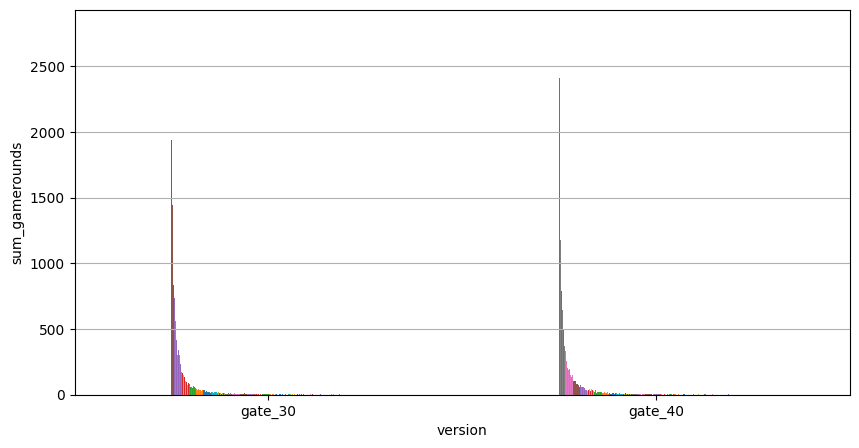

In [72]:
plt.style.use('default')

CrosstabResult=pd.crosstab(index=data['version'],columns=data['sum_gamerounds'])
#print(CrosstabResult)

CrosstabResult.plot.bar(figsize=(10,5), rot = 0, legend=False)
plt.ylabel("sum_gamerounds", size=10)
plt.grid(axis = 'y')

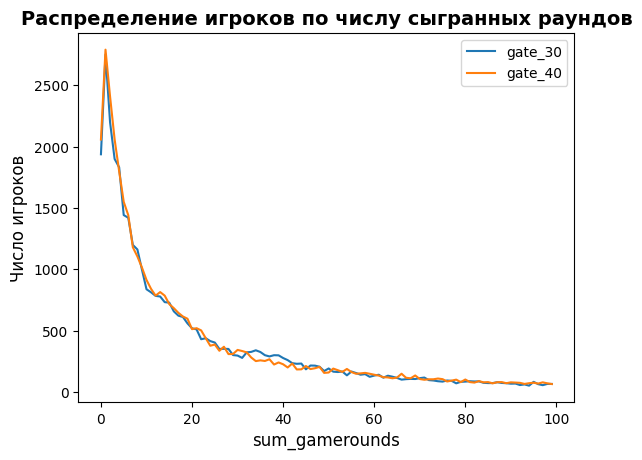

In [76]:
# Распределение игровых раундов

# Подсчет количества игроков для каждого количества sum_gamerounds по группам
plot_df_30 = data[data.version =='gate_30'].groupby("sum_gamerounds")["userid"].count()
plot_df_40 = data[data.version =='gate_40'].groupby("sum_gamerounds")["userid"].count()

# Составление графика распределения игроков, сыгравших от 0 до 100 sum_gamerounds
ax1 = plot_df_30.head(100).plot(label='gate_30')
ax2 = plot_df_40.head(100).plot(label='gate_40')
plt.title("Распределение игроков по числу сыгранных раундов", fontweight="bold", size=14)
plt.xlabel("sum_gamerounds", size=12)
plt.ylabel("Число игроков", size=12)
ax1.legend()
plt.show(ax1, ax2)

Как видно из графиков, распределения в обоих группах очень похожи.<br>
Также мы видим, что достаточное кол-во игроков в обоих группах устанавливают игру, но в дальнейшем не играют в неё.<br>
Найдём их кол-во:

In [74]:
data[data.sum_gamerounds == 0].userid.count()

3994

3994 игрока никогда не играли в игру, просто установили ее.

Посчитаем процент игроков, которые возвращаются и играют в игру 1 день и 7 дней после того, как они установили ее.<br>
Чем выше возврат игроков, тем интересней игра.<br>
В качестве первого шага посмотрим на переменные retention_1 и retention_7.

In [75]:
data.retention_1.value_counts()

0    50036
1    40153
Name: retention_1, dtype: int64

In [77]:
data.retention_1.value_counts(normalize=True)

0    0.55479
1    0.44521
Name: retention_1, dtype: float64

retention_1 - вернулся ли игрок и сыграл через 1 день после установки?<br>
Видим достаточно большой процент 44.5% игроков, которые играют на следующий день после установки.

In [78]:
data.retention_7.value_counts()

0    73408
1    16781
Name: retention_7, dtype: int64

In [79]:
data.retention_7.value_counts(normalize=True)

0    0.813935
1    0.186065
Name: retention_7, dtype: float64

retention_7 - вернулся ли игрок и сыграл через 7 дней после установки?<br>
После 7 дней интерес у пользователей значительно падает.<br>
Уже осталось только 18.6%

Посмотрим распределение этих же переменных по группам:

<Figure size 1200x1200 with 0 Axes>

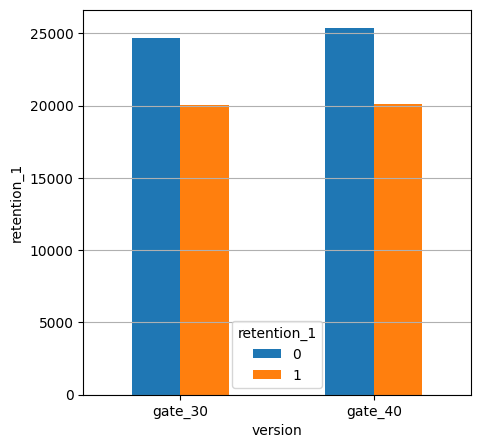

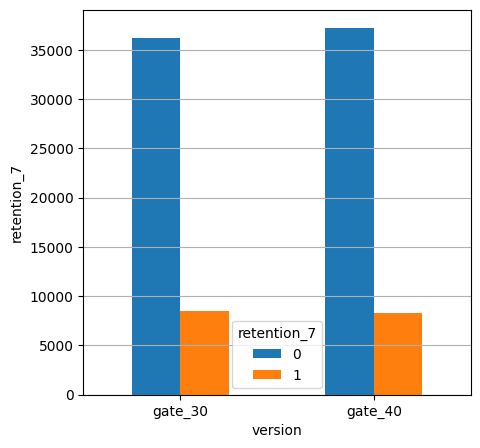

In [80]:
plt.style.use('default')

CrosstabResult=pd.crosstab(index=data['version'],columns=data['retention_1'])
#print(CrosstabResult)

plt.figure(figsize=(12, 12))
#plt.subplot(3, 4, 1)
CrosstabResult.plot.bar(figsize=(5,5), rot = 0)
plt.ylabel("retention_1", size=10)
plt.grid(axis = 'y')

CrosstabResult=pd.crosstab(index=data['version'],columns=data['retention_7'])
#plt.subplot(3, 4, 6)
CrosstabResult.plot.bar(figsize=(5,5), rot = 0)
plt.ylabel("retention_7", size=10)
plt.grid(axis = 'y')

Посмотрим сводную таблицу:

In [81]:
data_retention = data.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
data_retention

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


Мы видим небольшое снижение показателе в контрольной группе (gate_40) всех показателей,<br>
но даже небольшие изменения могут оказать большое влияние.<br>
Пока мы не можем точно сказать, что данные в контрольной группе статистически значимо хуже.

##Проверка гипотез (A/B-тест)
Выполним статистический тест для сравнения этих двух групп.<br>
Учитывая наш большой размер выборки, мы можем использовать ***z-тест*** для расчета нашего p-значения.<br> В противном случае вместо этого может быть выполнен тест t-student.

Давайте рассчитаем p-значение и доверительный интервал для каждой группы

**retention_1** - вернулся ли игрок и сыграл через 1 день после установки?

In [92]:
data['retention_1'].value_counts()

0    50036
1    40153
Name: retention_1, dtype: int64

In [117]:
k1 = data[data['version']=='gate_30']['retention_1'].sum()
k2 = data[data['version']=='gate_40']['retention_1'].sum()
k1, k2

(20034, 20119)

In [118]:
n1 = data[data['version']=='gate_30'].shape[0]
n2 = data[data['version']=='gate_40'].shape[0]
n1, n2

(44700, 45489)

In [96]:
from statsmodels.stats import proportion

In [97]:
z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]),
                                                 np.array([n1, n2]))
print('Результаты z_score = %.3f, p-value = %.3f'%(z_score, z_pvalue))

Результаты z_score = 1.784, p-value = 0.074


In [98]:
if abs(z_pvalue) < 0.05:
    print("Мы можем отвергнуть нулевую гипотезу! Стат. значимость существует.")
else:
    print("Мы не можем отвергнуть нулевую гипотезу. Стат. значимость не обнаружена.")

Мы не можем отвергнуть нулевую гипотезу. Стат. значимость не обнаружена.


In [99]:
(lower_con, lower_treat), (upper_con, upper_treat) = proportion.proportion_confint(np.array([k1, k2]),
                                                                                   np.array([n1, n2]), alpha=0.05)
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

ci 95% for control group: [0.444, 0.453]
ci 95% for treatment group: [0.438, 0.447]


**По показателю retention_1 мы не обнаружили статистически занчимых различий между контрольной и тестовой группой.**

**retention_7** - вернулся ли игрок и сыграл через 7 дней после установки?

In [100]:
data['retention_7'].value_counts()

0    73408
1    16781
Name: retention_7, dtype: int64

In [121]:
k1 = data[data['version']=='gate_30']['retention_7'].sum()
k2 = data[data['version']=='gate_40']['retention_7'].sum()
k1, k2

(8502, 8279)

In [103]:
z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]),
                                                 np.array([n1, n2]))
print('Результаты z_score = %.3f, p-value = %.3f'%(z_score, z_pvalue))

Результаты z_score = 3.164, p-value = 0.002


In [104]:
if abs(z_pvalue) < 0.05:
    print("Мы можем отвергнуть нулевую гипотезу! Стат. значимость существует.")
else:
    print("Мы не можем отвергнуть нулевую гипотезу. Стат. значимость не обнаружена.")

Мы можем отвергнуть нулевую гипотезу! Стат. значимость существует.


In [105]:
(lower_con, lower_treat), (upper_con, upper_treat) = proportion.proportion_confint(np.array([k1, k2]),
                                                                                   np.array([n1, n2]), alpha=0.05)
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

ci 95% for control group: [0.187, 0.194]
ci 95% for treatment group: [0.178, 0.186]


**По показателю retention_7 мы обнаружили статистически значимые различия между контрольной и тестовой группой.**<br>
В контрольной группе показатели лучше.

Ещё раз проверим параметр retention_7.<br>
Наилучший метод чтобы проверить статистическую значимость изменения для пропорций это метод Хи‑Квадрат.<br>
***Непараметрический Хи-квадрат:***

In [125]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([k1, k2]),
                                                        np.array([n1, n2]))

# Рассчитаем доверительный интервал для изменения
lift = (n1/n2)/(k1/k2)
std_error = np.sqrt(1/n1 + 1/n2 + 1/k1 + 1/k2)
ci = norm.interval(0.95, loc=lift, scale=std_error)

# Выводим результаты
print(f"Хи-квадрат = {chisq} p-value = {pvalue}")
print("Доверительный интервал изменения: ", ci)

Хи-квадрат = 10.01316732868897 p-value = 0.0015542499756142788
Доверительный интервал изменения:  (0.9239231569529299, 0.9898387732541497)


In [126]:
if abs(pvalue) < 0.05:
    print("Мы можем отвергнуть нулевую гипотезу! Стат. значимость существует.")
else:
    print("Мы не можем отвергнуть нулевую гипотезу. Стат. значимость не обнаружена.")

Мы можем отвергнуть нулевую гипотезу! Стат. значимость существует.



***Непараметрический критерий Манна-Уитни:***

In [128]:
data.groupby('version')['retention_7'].describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44700.0,0.190201,0.392464,0.0,0.0,0.0,0.0,1.0
gate_40,45489.0,0.182000,0.385849,0.0,0.0,0.0,0.0,1.0


In [133]:
mw_stats = mannwhitneyu(x=data[data['version'] == 'gate_30']['retention_7'].values,
                        y=data[data['version'] == 'gate_40']['retention_7'].values,
                        alternative='two-sided')
mw_stats

MannwhitneyuResult(statistic=1025017239.0, pvalue=0.001554344685704005)

In [134]:
print("Mann-Whitney U-test:")
print("U-statistic: ", mw_stats[0])
print("p-value:     ", mw_stats[1])

Mann-Whitney U-test:
U-statistic:  1025017239.0
p-value:      0.001554344685704005


In [135]:
if abs(mw_stats[1]) < 0.05:
    print("Мы можем отвергнуть нулевую гипотезу! Стат. значимость существует.")
else:
    print("Мы не можем отвергнуть нулевую гипотезу. Стат. значимость не обнаружена.")

Мы можем отвергнуть нулевую гипотезу! Стат. значимость существует.


Мы проверили 3 критериями: z-тест, Хи-квадрат и Манна-Уитни.<br>
***Стат. значимость по критерию retention_7 обнаружена!***

Стат. значимость по критерию retention_1 не обнаружена.

##Расчет мощности


***Статистическая мощность проверки гипотезы*** - это вероятность обнаружения эффекта, если существует истинный эффект, который необходимо обнаружить.
Мощность может быть рассчитана и зарегистрирована для завершенного эксперимента, чтобы прокомментировать уверенность, которую можно иметь в выводах, сделанных на основе результатов исследования.

d = (M1 – M2) / S_pooled






## S_pooled =

  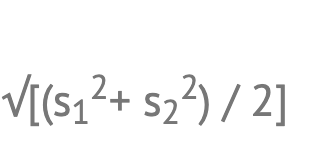

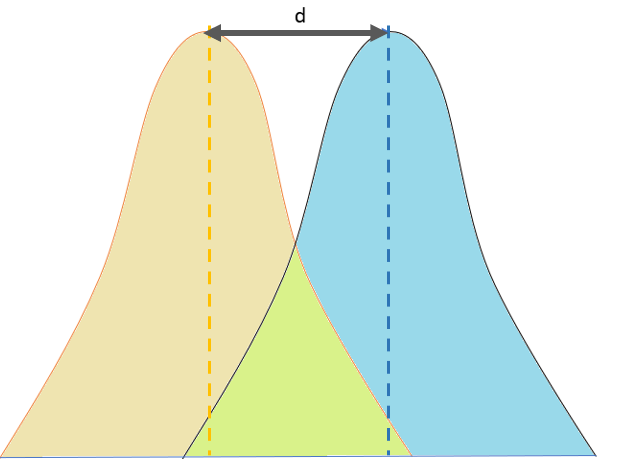

In [152]:
control = data.query('version == "gate_30"')
test = data.query('version == "gate_40"')

In [153]:
C_mean = control.retention_7.values.mean()
T_mean = test.retention_7.values.mean()

C_std = control.retention_7.values.std()
T_std = test.retention_7.values.std()

In [154]:
print(len(control.retention_7.values), len(test.retention_7.values))

44700 45489


In [155]:
n =  len(control.retention_7.values)

In [156]:
##S = np.sqrt((sd_t**2 / n_t) + (sd_c**2 / n_c))

S = np.sqrt((T_std**2 + C_std **2)/ 2)

In [157]:
effect =float((T_mean-C_mean)/ S)

In [158]:
# parameters for power analysis

alpha = 0.05

# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=None, nobs1=n, ratio=1.0, alpha=alpha)

result

0.8830851144014207

***Статистическая мощность*** — это вероятность того, что тест правильно отклонит ложную нулевую гипотезу.<br>
Получили достаточно высокую мощность теста, примерно 88.3%<br>
Между выборками есть различия с вероятностью 88.3%

## Выводы:

1. У нас есть статистически значимая разница по метрике удержаний retention_7 между контрольной  и тестовой группами. А эта метрика является наиболее важной.
2. Тест был поставлен корректно, каждый пользователь встречается только один раз и не попадает в разные группы.
3. Мощность теста достаточная, чтобы с уверенностью 88.3% сказать, что у нас действительно есть статистически значимое различие между группами.
4. У нас достаточный объём выборки.

##Рекомендации менеджеру:

1. **Не рекомендую выкатывать изменения в продакшен.**<br>
Новая версия игры (gate-40) показывает статистически значимые различия со старой версией игры (gate-30) с уверенностью 88.3%.<br>
В контрольной группе (gate-30) показатели по метрике удержаний игроков retention_7 лучше по сравнению с тестовой группой (gate-40).
2. Оставляем контрольную версию игры (gate-30).
3. Работаем над новой тестовой версией игры.